In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots

# Import Danych

In [2]:
import json
from pathlib import Path, PurePath
from io_utils.utils import get_latest_file_from_directory
from stitch.rectify.FrameRectifier import FrameRectifier

file_extension = "avi"
# file_extension = "csv"
dir_paths = [
    "resources/speeds/same_wagony/",
    # "resources/speeds/full_train/",
    "resources/speeds/full_train_speed_up/",
]

rectify_config = "resources/best.json"
with open(rectify_config) as f:
    rectify_config = json.load(f)

frame_size = (1920, 1080)
frame_rectifier = FrameRectifier(rectify_config, *frame_size)
frame_rectifier.calc_maps()

files_paths = [get_latest_file_from_directory(dir_path, file_extension) for dir_path in dir_paths]
files_paths = [PurePath(file_path) for file_path in files_paths]

files = {}
for file_path in files_paths:
    parent_dir_name = file_path.parent.name
    files[parent_dir_name] = str(file_path)
    # files[parent_dir_name] = pd.read_csv(file_path)

files


{'same_wagony': 'resources\\speeds\\same_wagony\\same_wagony.avi',
 'full_train_speed_up': 'resources\\speeds\\full_train_speed_up\\full_train_speed_up.avi'}

In [3]:

import copy
from speed_analyse_scripts.Measurement import Measurement
from speed_analyse_scripts.Timer import Timer
from stitch.speed.VelocityEstimator import VelocityEstimator
from stitch.speed.regression.FilterErrorMethod import FilterErrorMethod
from stitch.speed.regression.LstsqMethod import LstsqMethod
from stitch.speed.regression.MeanMethod import MeanMethod
from stitch.speed.regression.MedianMethod import MedianMethod
from stitch.speed.regression.OlsMethod import OlsMethod
from stitch.speed.regression.WlsMethod import WlsMethod

velocity_estimators = {
    "lstsq": VelocityEstimator(LstsqMethod(), LstsqMethod()),
    "OLS": VelocityEstimator(OlsMethod(), OlsMethod()),
    "WLS": VelocityEstimator(WlsMethod(), WlsMethod()),
    # "Mean": VelocityEstimator(MeanMethod(), MeanMethod(), center=False),
    # "Median": VelocityEstimator(MedianMethod(), MedianMethod(), center=False),
    "Filter": VelocityEstimator(FilterErrorMethod(False), FilterErrorMethod(False), center=False),
    "Filter_R": VelocityEstimator(FilterErrorMethod(True), FilterErrorMethod(True), center=False),
}

raw_velocities = {key: [] for key, value in files.items()}

measurements = []
for file_name in files.keys(): 
    for method_name, estimator in velocity_estimators.items():
        velocity_estimator = copy.deepcopy(estimator)

        measurement = Measurement(file_name, method_name, velocity_estimator, [], Timer())
        measurements.append(measurement)

print(raw_velocities)
measurements


{'same_wagony': [], 'full_train_speed_up': []}


[Measurement(dataset_name='same_wagony', method_name='lstsq', velocity_estimator=<stitch.speed.VelocityEstimator.VelocityEstimator object at 0x000002BEB69886A0>, results=[], timer=<speed_analyse_scripts.Timer.Timer object at 0x000002BEB3AF3820>),
 Measurement(dataset_name='same_wagony', method_name='OLS', velocity_estimator=<stitch.speed.VelocityEstimator.VelocityEstimator object at 0x000002BEB69889A0>, results=[], timer=<speed_analyse_scripts.Timer.Timer object at 0x000002BEB6988910>),
 Measurement(dataset_name='same_wagony', method_name='WLS', velocity_estimator=<stitch.speed.VelocityEstimator.VelocityEstimator object at 0x000002BEB6988D60>, results=[], timer=<speed_analyse_scripts.Timer.Timer object at 0x000002BEB6988CA0>),
 Measurement(dataset_name='same_wagony', method_name='Filter', velocity_estimator=<stitch.speed.VelocityEstimator.VelocityEstimator object at 0x000002BEB69952E0>, results=[], timer=<speed_analyse_scripts.Timer.Timer object at 0x000002BEB6988DC0>),
 Measurement(da

# Testy metod na zbiorach

In [4]:
import cv2
from tqdm import tqdm

def measure_velocity_from_movie(movie_path, dataset_name, frame_rectifier, *measurements, max_frames=-1, min_frames=-1):
    input_cam = cv2.VideoCapture(movie_path)
    total_frames = input_cam.get(cv2.CAP_PROP_FRAME_COUNT)

    counter = 0
    with tqdm(total=total_frames, desc=dataset_name) as pbar:
        while input_cam.isOpened():
            ret, frame = input_cam.read()

            if counter < min_frames and min_frames > 0:
                counter += 1
                pbar.update(1)
                continue

            if counter > max_frames and max_frames > 0:
                pbar.close()
                break

            if ret:

                frame = frame_rectifier.rectify(frame)
                append_raw_velocity = True

                for measurement in measurements:
                    measurement.timer.start()
                    velocity = measurement.velocity_estimator.get_velocity(frame)
                    measurement.timer.stop()
                    
                    result = (counter, velocity[0], velocity[1])
                    measurement.results.append(result)

                    if append_raw_velocity:
                        measurement = measurements[0]
                        raw_velocity = measurement.velocity_estimator.old_raw_velocity
                        raw_velocities[dataset_name].append(raw_velocity)
                        append_raw_velocity = False
            else:
                break

            counter += 1
            pbar.update(1)
            


    input_cam.release()

In [5]:
for dataset_name, file_path in files.items():
    frame_size = (1920, 1080)
    frame_rectifier = FrameRectifier(rectify_config, *frame_size)
    frame_rectifier.calc_maps()

    selected_measurements = filter(lambda x: x.dataset_name == dataset_name, measurements)
    selected_measurements = list(selected_measurements)

    min_frames = -1
    max_frames = -1
    measure_velocity_from_movie(file_path, dataset_name, frame_rectifier, max_frames=max_frames, min_frames=min_frames, *selected_measurements)    

values = [i.timer.elapsed_time for i in measurements]
values

same_wagony:   0%|          | 0/308.0 [00:00<?, ?it/s]c:\Users\wrzezniczak\Desktop\onyks_owl\poc\stitch\speed\regression\WlsMethod.py:43: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (mod_fv ** 2)
same_wagony: 100%|██████████| 308/308.0 [01:26<00:00,  3.55it/s]
full_train_speed_up: 100%|██████████| 3487/3487.0 [14:01<00:00,  4.14it/s]


[0.05102170907057725,
 0.05033677274530584,
 0.054182969130478896,
 0.050490818240425804,
 0.05221218954433094,
 0.04493699724707728,
 0.04480161932159503,
 0.04549855744219934,
 0.04431970611082164,
 0.04415721287520868]

In [6]:
from functools import reduce

from speed_analyse_scripts.pd_utils import filter_error

filtered = {}
for key, value in raw_velocities.items():
    if len(value) != 0:
        concatenated_array = reduce(lambda a, b: np.append(a, b, axis=0), value)
        raw_velocities[key] = concatenated_array

        df = pd.DataFrame(concatenated_array)
        headers = ["frame", "x", "y"]
        df.columns = headers
        filtered[key] = filter_error(df).to_numpy()
        

In [7]:
raw_velocities

{'same_wagony': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.00000000e+00, -2.30334930e+01,  1.46942139e-01],
        [ 1.00000000e+00, -2.32564697e+01,  3.39691162e-01],
        ...,
        [ 3.07000000e+02, -2.32329102e+01, -2.89733887e-01],
        [ 3.07000000e+02, -2.46079102e+01,  5.70106506e-03],
        [ 3.07000000e+02, -2.51809082e+01,  1.92298889e-01]]),
 'full_train_speed_up': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.10000000e+01, -1.20199585e+00, -4.84729767e-01],
        [ 8.70000000e+01, -1.42355347e+00, -9.83142853e-01],
        ...,
        [ 3.24300000e+03, -3.83473969e+01,  1.67578125e+00],
        [ 3.37000000e+03, -1.60464478e+00, -9.52392578e-01],
        [ 3.42100000e+03, -1.31497192e+00, -1.85300827e-01]])}

# Porównanie metod regresji

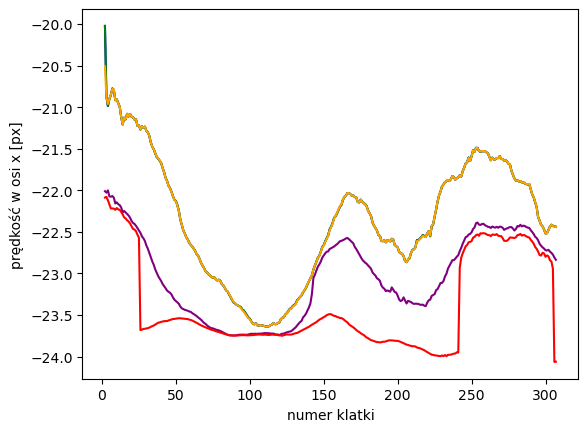

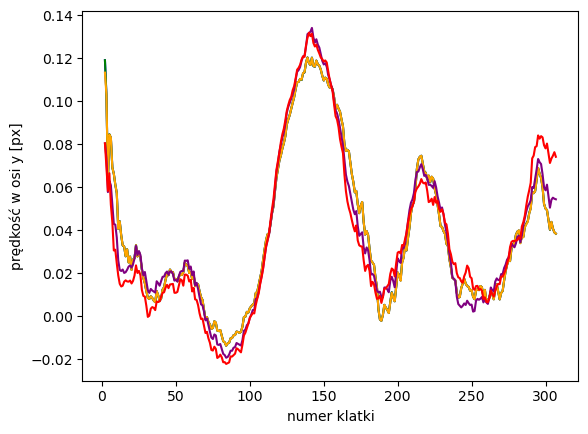

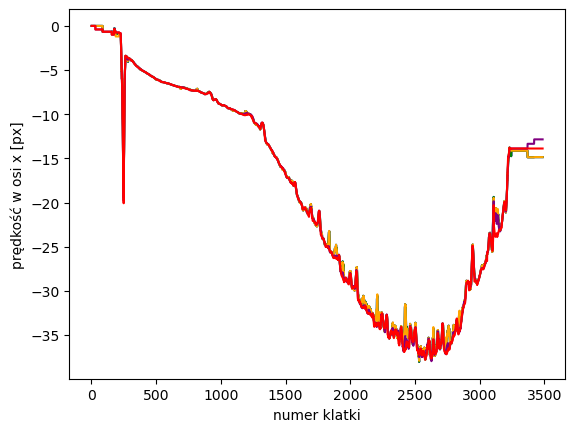

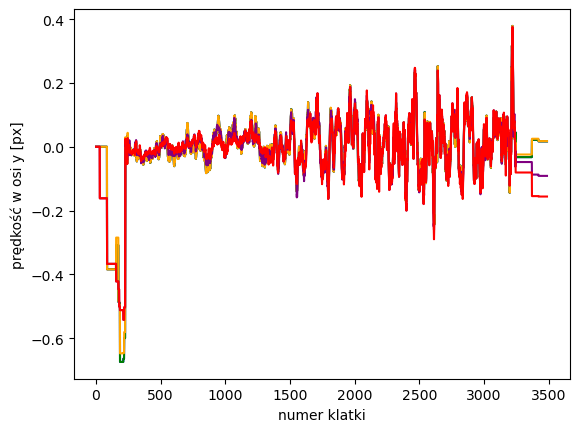

In [42]:
from matplotlib import pyplot as plt

from display.ComposedPlot import ComposedPlot




def ax1_call_x(axe):
    color = "tab:blue"
    axe.set_xlabel("frame")
    axe.set_ylabel("prędkość x", color=color)
    axe.tick_params(axis='y', labelcolor=color)

def ax2_call_x(axe):
    axe.set_ylabel("prędkość w osi x [px]")
    axe.set_xlabel("numer klatki")

def ax2_call_y(axe):
    axe.set_ylabel("prędkość w osi y [px]")
    axe.set_xlabel("numer klatki")

Composed_plots = {}

for dataset_name in files.keys():
    # ax_callbacks = [ax1_call, ax2_call]
    ax_callbacks = [ax2_call]

    title = f"film: {dataset_name}, wszystkie metody, prędkość w osi x"
    Composed_x = ComposedPlot(title, ax2_call_x)	
    title = f"film: {dataset_name}, wszystkie metody, prędkość w osi y"
    Composed_y = ComposedPlot(title, ax2_call_y)

    Composed_plots[f"{dataset_name}_wszystkie_x"] = Composed_x
    Composed_plots[f"{dataset_name}_wszystkie_y"] = Composed_y


    colors = ["blue", "green", "orange", "purple", "red"]
    # color = (np.random.random(), np.random.random(), np.random.random())


    # original = raw_velocities[dataset_name] 
    # x = original[:, 0]
    # y = original[:, 1]
    # Composed_x.add_plot(0, x, y, color="grey", label="original x")

    # _filtered = filtered[dataset_name] 
    # x = _filtered[:, 0]
    # y = _filtered[:, 1]
    # Composed_x.add_plot(1, x, y, color="grey", label="filtered x")
    
    selected_measurements = filter(lambda x: x.dataset_name == dataset_name, measurements)
    selected_measurements = list(selected_measurements)

    for measurement, color in zip(selected_measurements, colors):
        array = np.array(measurement.results)
        frame = array[2:, 0]
        x = array[2:, 1]
        y = array[2:, 2]
        Composed_x.add_plot(0, frame, x, color=color, label=measurement.method_name)
        Composed_y.add_plot(0, frame, y, color=color, label=measurement.method_name)

        # method_title = f"film: {dataset_name}, metoda: {measurement.method_name}"
        # Composed_method_x = ComposedPlot(method_title, ax2_call_x)
        # Composed_method_x.add_plot(0, frame, x, color=color, label=measurement.method_name)
        # Composed_plots[f"{dataset_name}_{measurement.method_name}_x"] = Composed_method_x

        # Composed_method_y = ComposedPlot(method_title, ax2_call_y)	
        # Composed_method_y.add_plot(0, frame, y, color=color, label=measurement.method_name)
        # Composed_plots[f"{dataset_name}_{measurement.method_name}_y"] = Composed_method_y

# [i.show_composed() for i in Composed_plots.values()]

In [41]:
# import os
# output_dir = r"C:\Users\wrzezniczak\Desktop\wagony_sprawozdanie\wykresy" 

# for name, plot in Composed_plots.items():
#     file_name = f"{name}.png"
#     path = os.path.join(output_dir, file_name)
#     plot.save_composed(path)


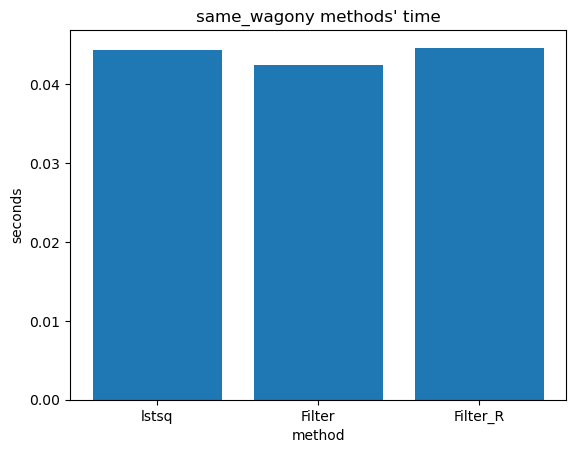

In [ ]:
names = [i.method_name for i in measurements]
values = [i.timer.elapsed_time for i in measurements]
plt.bar(names, values)
plt.title(f"{dataset_name} methods' time")
plt.xlabel("method")
plt.ylabel("seconds")
plt.show()

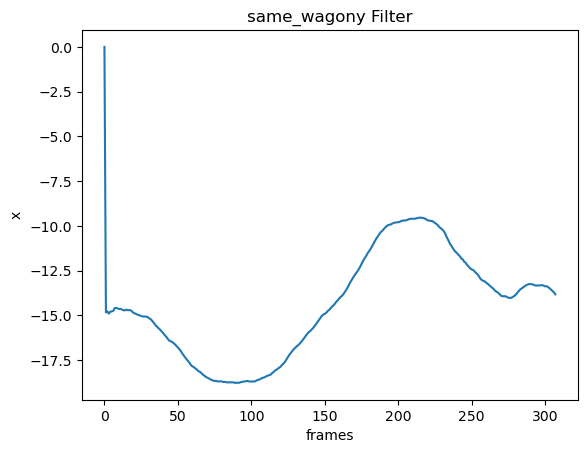

In [ ]:


dataset = 'same_wagony'
method = 'Filter'
def select_measurement(measurement):
    return measurement.dataset_name == dataset and measurement.method_name == method

selected_measurement = list(filter(select_measurement, measurements))[0]
results = np.array(selected_measurement.results)
frame = results[:, 0]
x = results[:, 1]

plt.plot(frame, x)
plt.title(f"{dataset} {method}")
plt.xlabel("frames")
plt.ylabel("x")
plt.show()


In [ ]:
measurements[0].results
measurements[1].results

[(0, 0.0, 0.0),
 (1, -14.8388732486301, 0.06391875261671087),
 (2, -14.777631824666804, 0.053497643664825796),
 (3, -14.90943894350439, 0.050154087635187),
 (4, -14.800872220831403, 0.03856909824723125),
 (5, -14.781994898747739, 0.04540870161617504),
 (6, -14.753300514880161, 0.03807849977530685),
 (7, -14.601198649485642, 0.033024819476090386),
 (8, -14.586086267616317, 0.025813705351815295),
 (9, -14.617937773272839, 0.027443662364646872),
 (10, -14.64933441516965, 0.022818165267165087),
 (11, -14.642409025493421, 0.01660985613381991),
 (12, -14.680791473388672, 0.013636394267695223),
 (13, -14.719216393199613, 0.013567060582778033),
 (14, -14.725217369411848, 0.013902012533789513),
 (15, -14.687254247037412, 0.01436881765326797),
 (16, -14.719884670658399, 0.014598226808283451),
 (17, -14.705086353004619, 0.014601153360609336),
 (18, -14.729537812682294, 0.014389540484541805),
 (19, -14.802852466800907, 0.014934517231881252),
 (20, -14.879800791077843, 0.013425502612769046),
 (21, 